### Weight Decay(Lasso, Ridge, ElasticNet) 적용해보기

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import time

In [3]:
# Personal Loan 데이터 불러오기
ploan = pd.read_csv("./data/Personal Loan.csv")
ploan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
"""
Experience 경력
Income 수입
Family 가족단위
CCAvg 월 카드사용량
Education 교육수준 (1: undergrad, 2:Graduate, 3:Advance)
Mortgage 가계대출
Securities account 유가증권계좌 유무
CD account 양도예금증서계좌 유무
Online 온라인계좌 유무
CreditCard 신용카드 유무
"""

'\nExperience 경력\nIncome 수입\nFamily 가족단위\nCCAvg 월 카드사용량\nEducation 교육수준 (1: undergrad, 2:Graduate, 3:Advance)\nMortgage 가계대출\nSecurities account 유가증권계좌 유무\nCD account 양도예금증서계좌 유무\nOnline 온라인계좌 유무\nCreditCard 신용카드 유무\n'

In [4]:
# 의미없는 변수 제거 : ID, zip code 제거
ploan_processed = ploan.dropna().drop(['ID', 'ZIP Code'], axis=1, inplace=False)

feature_columns = list(ploan_processed.columns.difference(['Personal Loan']))
X = ploan_processed[feature_columns]
Y = ploan_processed['Personal Loan']

train_x, test_x, train_y, test_y = train_test_split(X, Y, stratify=Y, train_size=0.7, test_size=0.3, random_state=42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1750, 11) (750, 11) (1750,) (750,)


In [22]:
# Lasso 적합
l1 = Lasso(alpha=0.01) # alpha 값은 lambda를 의미함
l1.fit(train_x, train_y)

Lasso(alpha=0.01)

In [23]:
# 회귀계수 출력 (불필요한 변수는 0으로 제거해줌)
table = pd.DataFrame(data={'parameter': feature_columns, 'coef': l1.coef_, 'grad': np.exp(l1.coef_)})
table

,parameter,coef,grad
0,Age,0.000000,1.000000
1,CCAvg,0.002048,1.002050
2,CD Account,0.114390,1.121190
3,CreditCard,-0.000000,1.000000
4,Education,0.065834,1.068050
5,Experience,0.000477,1.000477
6,Family,0.031340,1.031836
7,Income,0.003554,1.003560
8,Mortgage,0.000013,1.000013
9,Online,0.000000,1.000000


In [24]:
pred_y_lasso = l1.predict(test_x)

In [25]:
def cut_off(y, threshold):
    Y = y.copy()
    Y[Y>threshold]=1
    Y[Y<=threshold]=0
    return (Y.astype(int))

def accuracy(cfmat):
    acc = (cfmat[0,0]+cfmat[1,1])/cfmat.sum()
    return acc

In [26]:
# cut-off using threshold 0.5
pred_Y_lasso = cut_off(pred_y_lasso, 0.5)

# confusion matrix
cfmat_lasso = confusion_matrix(test_y, pred_Y_lasso)
print(cfmat_lasso)
print('accuracy :', accuracy(cfmat_lasso))

[[672   1]
 [ 47  30]]
accuracy : 0.936


AUC:  0.9439995368672931


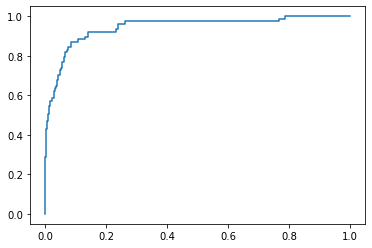

In [30]:
# ROC 커브 시각화
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y_lasso, pos_label=1)
plt.plot(fpr, tpr)

# AUC 면적 구하기
auc = np.trapz(tpr, fpr)
print('AUC: ', auc)

In [27]:
# Ridge 적합
l2 = Ridge(alpha=0.01) # alpha 값은 lambda를 의미함
l2.fit(train_x, train_y)

Ridge(alpha=0.01)

In [28]:
# 회귀계수 출력 (특정변수가 0에 가까워지긴 하지만 완전히 0이 되지는 않음)
table = pd.DataFrame(data={'parameter': feature_columns, 'coef': l2.coef_, 'grad': np.exp(l2.coef_)})
table

,parameter,coef,grad
0,Age,-0.003713,0.996294
1,CCAvg,0.007376,1.007403
2,CD Account,0.354974,1.426144
3,CreditCard,-0.052858,0.948515
4,Education,0.078340,1.081491
5,Experience,0.004128,1.004137
6,Family,0.036250,1.036916
7,Income,0.003274,1.003279
8,Mortgage,0.000002,1.000002
9,Online,-0.019130,0.981052


In [29]:
pred_y_ridge = l2.predict(test_x)

# cut-off using threshold 0.5
pred_Y_ridge = cut_off(pred_y_ridge, 0.5)

# confusion matrix
cfmat_ridge = confusion_matrix(test_y, pred_Y_ridge)
print(cfmat_ridge)
print('accuracy :', accuracy(cfmat_ridge))

[[669   4]
 [ 47  30]]
accuracy : 0.932


AUC:  0.9494992377607533


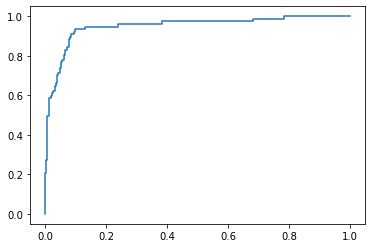

In [32]:
# ROC 커브 시각화
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y_ridge, pos_label=1)
plt.plot(fpr, tpr)

# AUC 면적 구하기
auc = np.trapz(tpr, fpr)
print('AUC: ', auc)

**Lambda(alpha) 값에 따른 회귀계수 및 accuracy 계산**

In [42]:
# lambda 값 0.001 ~ 100 까지 범위설정
alpha = np.logspace(-3, 2, 6)

In [49]:
# Lasso 축소법 적용
data = []
acc_table = []
for i, a in enumerate(alpha):
    lasso = Lasso(alpha=a).fit(train_x, train_y)
    data.append(pd.Series(np.hstack([lasso.intercept_, lasso.coef_])))
    pred_y = lasso.predict(test_x)
    pred_y = cut_off(pred_y, 0.5)
    cfmat = confusion_matrix(test_y, pred_y)
    acc_table.append((accuracy(cfmat)))

df_lasso = pd.DataFrame(data, index=alpha).T
acc_table_lasso = pd.DataFrame(acc_table, index=alpha).T

In [50]:
df_lasso
# Lambda 값이 커질수록 대다수의 변수들이 0으로 제거됨

,0.001,0.010,0.100,1.000,10.000,100.000
0,-0.335006,-0.381869,-0.143698,-0.113103,0.102286,0.102286
1,-0.002109,0.000000,0.000000,0.000000,-0.000000,-0.000000
2,0.006829,0.002048,0.000000,0.000000,0.000000,0.000000
3,0.322174,0.114390,0.000000,0.000000,0.000000,0.000000
4,-0.043385,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
5,0.076771,0.065834,0.000000,0.000000,0.000000,0.000000
6,0.002534,0.000477,0.000000,0.000000,-0.000000,-0.000000
7,0.035728,0.031340,0.000000,0.000000,0.000000,0.000000
8,0.003313,0.003554,0.003291,0.002893,0.000000,0.000000
9,0.000004,0.000013,0.000016,0.000000,0.000000,0.000000


In [51]:
acc_table_lasso
# Lambda 값이 0.01일때 가장 성능이 좋음

,0.001,0.010,0.100,1.000,10.000,100.000
0,0.932,0.936,0.894667,0.897333,0.897333,0.897333


In [52]:
# Lasso 축소법 적용
data = []
acc_table = []
for i, a in enumerate(alpha):
    ridge = Ridge(alpha=a).fit(train_x, train_y)
    data.append(pd.Series(np.hstack([ridge.intercept_, ridge.coef_])))
    pred_y = ridge.predict(test_x)
    pred_y = cut_off(pred_y, 0.5)
    cfmat = confusion_matrix(test_y, pred_y)
    acc_table.append((accuracy(cfmat)))

df_ridge = pd.DataFrame(data, index=alpha).T
acc_table_ridge = pd.DataFrame(acc_table, index=alpha).T

In [53]:
df_ridge
# Lambda 값이 커져도 변수들이 0이 되지않음

,0.001,0.010,0.100,1.000,10.000,100.000
0,-0.289557,-0.289565,-0.289645,-0.290438,-0.297581,-0.335283
1,-0.003713,-0.003713,-0.003713,-0.003716,-0.003723,-0.002998
2,0.007376,0.007376,0.007376,0.007378,0.007388,0.007247
3,0.355019,0.354974,0.354529,0.350141,0.311781,0.151924
4,-0.052866,-0.052858,-0.052782,-0.052037,-0.045541,-0.019307
5,0.078340,0.078340,0.078341,0.078347,0.078316,0.074774
6,0.004128,0.004128,0.004129,0.004136,0.004175,0.003592
7,0.036250,0.036250,0.036254,0.036289,0.036578,0.037026
8,0.003274,0.003274,0.003274,0.003278,0.003313,0.003449
9,0.000002,0.000002,0.000002,0.000002,0.000004,0.000014


In [55]:
acc_table_ridge
# Lambda 값에 대한 성능이 비슷함

,0.001,0.010,0.100,1.000,10.000,100.000
0,0.932,0.932,0.932,0.932,0.932,0.933333


**Lambda 값 변화에 따른 회귀계수 축소 시각화**

Text(0.5, 1.0, 'Ridge')

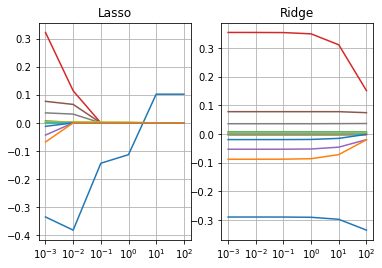

In [63]:
import matplotlib.pyplot as plt

ax1 = plt.subplot(121)
plt.semilogx(df_lasso.T)
plt.xticks(alpha)
plt.grid(True)
plt.title('Lasso')

ax2 = plt.subplot(122)
plt.semilogx(df_ridge.T)
plt.xticks(alpha)
plt.grid(True)
plt.title('Ridge')